In [1]:
#| default_exp mesh

In [2]:
#| export

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import igl
import copy

In [3]:
#| export

import jax
import jax.numpy as jnp

In [4]:
#| export

from jaxtyping import Float, Int, Bool, PyTree 
from typing import Any, Iterable, NamedTuple
from pathlib import Path
from enum import IntEnum

import dataclasses

import functools

In [5]:
#| export

from triangulax import trigonometry as trig
from triangulax.triangular import TriMesh

In [6]:
#| hide

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
jax.config.update('jax_log_compiles', False) # use this to log JAX JIT compilations.

In [7]:
#| hide

import jaxtyping


In [8]:
#| hide

%load_ext jaxtyping 
%jaxtyping.typechecker beartype.beartype

# enables type checking. does not work for some cells (vmapping and loading/saving). For those, disable type checks

## Half-edge meshes

In the `TriMesh` class, we represent a mesh a list of triangles. However, many common operations are difficult with this data structure. For example, how do you get all the neighbors of a given vertex, or compute the area of a dual cell?

For simulation and geometry processing, we need a different representation of the adjacency information. Typically, this is achieved by a [half-edge mesh](https://www.jerryyin.info/geometry-processing-algorithms/half-edge/) (HE) data structure. We represent the HE data structure by 3 sets of integer index arrays:

1. Vertices: 1 $(N_V,)$ matrix, whose entry for vertex $i$ is an arbitrary HE incident on $i$
2. Edges: 6 $(2N_E,)$ matrices, [`origin`, `dest`, `nxt`, `prv`, `twin`, `face`] for each half-edge (`face` is undefined for boundary half-edges).
3. Faces, 1 $(N_F, 1)$ matrix, whose entry for face $i$ is an arbitrary HE in $i$. (Not to be confused with the $(N_F, 3)$ matrix of _vertex IDs_ used previously).


Additionally, there are two float arrays for vertex and face positions, as previously. However, we split _combinatorial_ and _geometric_ information - a `HeMesh` class for the combinatorics, and a couple of regular arrays for the vertex positions, face positions, and vertex/half-edge/face attributes. The latter are packaged into a `GeomMesh` class. Together, the pair `(GeomMesh, HeMesh)` describes a mesh (like vertices/faces pair). A named tuple `Mesh` comines the two.

The first task is to create a helper function to plot mesh connectivity, and to create the half-edge connectivity matrices from the more conventional list-of-triangles format. The latter is somewhat involved.

We follow the notes in notebook 02 to ensure JAX compatibility.

In [9]:
#| export

def label_plot(vertices: Float[jax.Array, "n_vertices 2"],
               faces: Int[jax.Array, "n_faces 3"],
               hemesh: None | PyTree=None,
               vertex_labels: bool = True, face_labels: bool=True,
               ax: None | mpl.axes.Axes=None,
               fontsize: int|None = None) -> None:
    """For debugging purposes. Plot triangular mesh with face/vertex labels in black/blue.
    If hemesh is not None, the connectivity info from it is used to plot the half-edge labels."""
    ax = plt.gca() if ax is None else ax
    if vertex_labels:
        for iv, v in enumerate(vertices):
            ax.text(*(v+np.array([0,.025])), str(iv),
                    color="tab:blue", ha="center", fontsize=fontsize)
    if face_labels:
        for ifc, fc in enumerate(faces):
            centroid = np.mean([vertices[iv] for iv in fc], axis=0)
            ax.text(*centroid, str(ifc), color="k", fontsize=fontsize, ha="center",)
    if hemesh is not None:
        edge_center = (vertices[hemesh.dest] + vertices[hemesh.orig])/2
        for ie in np.where(hemesh.is_unique)[0]:
            ax.text(*edge_center[ie], f"{ie}/{hemesh.twin[ie]}",
            color="tab:orange", ha="center", fontsize=fontsize)
            
    return None

  o flat_tri_ecmc


(np.float64(-1.10003475),
 np.float64(1.09628575),
 np.float64(-1.09934025),
 np.float64(1.09050125))

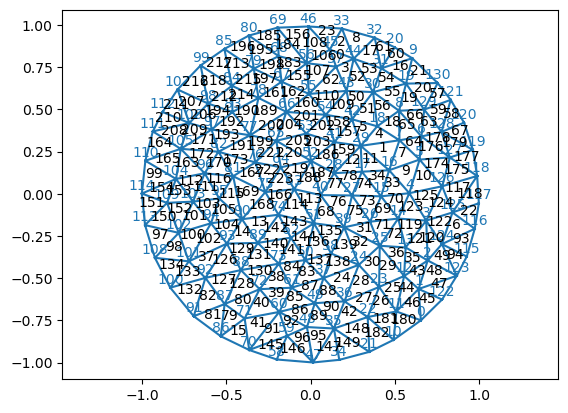

In [10]:
mesh = TriMesh.read_obj("test_meshes/disk.obj")

plt.triplot(*mesh.vertices.T, mesh.faces)
label_plot(mesh.vertices, mesh.faces, fontsize=10)
plt.axis("equal")

In [11]:
#| hide

def get_half_edge_arrays(n_vertices: int, faces: Int[jax.Array, "n_faces 3"]) -> list[Int[jax.Array, " n"]]:
    """
    Get half-edge data structure arrays from faces.

    Returns: incident, orig, dest, twin, nxt, prv, heface, face_incident
    """
    # form all unique edges, ordered lexicographically
    edges = np.array(sorted([sorted(x) for x in igl.edges(faces)]))
    half_edges = np.vstack([edges, edges[:,::-1]])

    # initialize the connectivity arrays
    orig, dest = (half_edges[:,0], half_edges[:, 1])
    twin = np.hstack([np.arange(edges.shape[0])+edges.shape[0], np.arange(edges.shape[0])])

    # iterate over faces to get face, prv, and nxt for each half-edge
    nxt, prv, heface = (np.ones_like(orig), np.ones_like(orig), -1*np.ones_like(orig),)
    for ifc, fc in enumerate(faces):
        for v_prv, v, v_nxt in zip(np.roll(fc, 1), fc, np.roll(fc, -1)):
            heface[(orig==v) & (dest==v_nxt)] = ifc
            nxt[(orig==v_prv) & (dest==v)] = np.where((orig==v) & (dest==v_nxt))[0][0]
            prv[(orig==v) & (dest==v_nxt)] = np.where((orig==v_prv) & (dest==v))[0][0]
    
    # finally, prv and nxt for the boundary hes
    for loop in igl.boundary_loop_all(faces):
        for v_nxt, v, v_prv in zip(np.roll(loop, 1), loop, np.roll(loop, -1)):
            nxt[(orig==v_prv) & (dest==v)] = np.where((orig==v) & (dest==v_nxt))[0][0]
            prv[(orig==v) & (dest==v_nxt)] = np.where((orig==v_prv) & (dest==v))[0][0]

    # get an incident half-edge for each vertex and face 
    incident = np.array([np.argmax(orig==v) for v in range(n_vertices)])
    face_incident = np.array([np.argmax(heface==ifc) for ifc, _ in enumerate(faces)])            

    return [jnp.array(arr) for arr in [incident, orig, dest, twin, nxt, prv, heface, face_incident]]

In [12]:
#| export

def get_half_edge_arrays_vectorized(n_vertices: int, faces: Int[jax.Array, "n_faces 3"]) -> list[Int[jax.Array, " n"]]:
    """
    Get half-edge data structure arrays from faces (vectorized).

    Returns: incident, orig, dest, twin, nxt, prv, heface, face_incident
    """
    # form all unique edges, ordered lexicographically
    faces_np = np.asarray(faces)
    edges = np.array(sorted([sorted(x) for x in igl.edges(faces_np)]))
    half_edges = np.vstack([edges, edges[:, ::-1]])

    # initialize the connectivity arrays. origin, destination, and twin are easy
    orig = half_edges[:, 0]
    dest = half_edges[:, 1]
    n_edges = edges.shape[0]
    twin = np.hstack([np.arange(n_edges) + n_edges, np.arange(n_edges)])

    n_hes = half_edges.shape[0]
    nxt = np.ones(n_hes, dtype=orig.dtype)
    prv = np.ones(n_hes, dtype=orig.dtype)
    heface = -1 * np.ones(n_hes, dtype=orig.dtype)

    # build mapping from (orig, dest) -> half-edge index via sorting
    order = np.lexsort((dest, orig))
    half_edges_sorted = half_edges[order]
    dtype = np.dtype([("o", half_edges_sorted.dtype), ("d", half_edges_sorted.dtype)])
    he_view = half_edges_sorted.view(dtype).ravel()

    def lookup(pairs: np.ndarray) -> np.ndarray:
        pairs_view = pairs.view(dtype).ravel()
        pos = np.searchsorted(he_view, pairs_view)
        return order[pos]

    # per-face half-edges (v0->v1, v1->v2, v2->v0)
    v0, v1, v2 = faces_np[:, 0], faces_np[:, 1], faces_np[:, 2]
    pairs0 = np.stack([v0, v1], axis=1)
    pairs1 = np.stack([v1, v2], axis=1)
    pairs2 = np.stack([v2, v0], axis=1)
    h0 = lookup(pairs0)
    h1 = lookup(pairs1)
    h2 = lookup(pairs2)

    ifc = np.arange(faces_np.shape[0])
    heface[h0] = ifc
    heface[h1] = ifc
    heface[h2] = ifc

    nxt[h0] = h1
    nxt[h1] = h2
    nxt[h2] = h0

    prv[h0] = h2
    prv[h1] = h0
    prv[h2] = h1

    # boundary loops (match reference orientation)
    for loop in igl.boundary_loop_all(faces_np):
        loop = np.asarray(loop)
        v_nxt = np.roll(loop, 1)
        v = loop
        v_prv = np.roll(loop, -1)
        hb0 = lookup(np.stack([v_prv, v], axis=1))
        hb1 = lookup(np.stack([v, v_nxt], axis=1))
        nxt[hb0] = hb1
        prv[hb1] = hb0

    # incident half-edge per vertex (minimum index in original ordering)
    order_orig = np.argsort(orig)
    orig_sorted = orig[order_orig]
    first = np.concatenate([[0], np.where(orig_sorted[1:] != orig_sorted[:-1])[0] + 1])
    incident = np.full(n_vertices, -1, dtype=orig.dtype)
    min_idx = np.minimum.reduceat(order_orig, first)
    incident[orig_sorted[first]] = min_idx

    # first half-edge per face (minimum index among the three)
    face_incident = np.minimum(np.minimum(h0, h1), h2)

    return [jnp.array(arr) for arr in [incident, orig, dest, twin, nxt, prv, heface, face_incident]]

In [13]:
mesh_high_res = TriMesh.read_obj("test_meshes/torus_high_resolution.obj")
mesh = TriMesh.read_obj("test_meshes/disk.obj")


  o Torus
  o flat_tri_ecmc


In [14]:
#| notest

%%timeit
results = get_half_edge_arrays(mesh.vertices.shape[0], mesh.faces)

UsageError: Line magic function `%%timeit` not found.


In [15]:
# test vectorized vs reference implementation for two meshes

mesh = TriMesh.read_obj("test_meshes/disk.obj")
ref = get_half_edge_arrays(mesh.vertices.shape[0], mesh.faces)
fast = get_half_edge_arrays_vectorized(mesh.vertices.shape[0], mesh.faces)

print("Equal?", all([jnp.array_equal(a, b) for a, b in zip(ref, fast)]))

mesh = TriMesh.read_obj("test_meshes/sphere.obj")
ref = get_half_edge_arrays(mesh.vertices.shape[0], mesh.faces)
fast = get_half_edge_arrays_vectorized(mesh.vertices.shape[0], mesh.faces)

print("Equal?", all([jnp.array_equal(a, b) for a, b in zip(ref, fast)]))

  o flat_tri_ecmc
  o Icosphere


Equal? True
Equal? True


In [17]:
#| notest

%timeit fast = get_half_edge_arrays_vectorized(mesh.vertices.shape[0], mesh.faces)

1.11 ms ± 43 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [18]:
#| notest

%time fast = get_half_edge_arrays_vectorized(mesh_high_res.vertices.shape[0], mesh_high_res.faces)

CPU times: user 211 ms, sys: 12.6 ms, total: 224 ms
Wall time: 221 ms


In [19]:
#| export

@jax.tree_util.register_dataclass
@dataclasses.dataclass(repr=False, eq=False, frozen=True)
class HeMesh:
    """
    Half-edge mesh data structure for triangular meshes.

    A half-edge mesh is described by a set of half-edges and several
    arrays that specify their connectivity (see markup explanation above).
    This class serves as a container for multiple arrays.
    For future compatibility with JAX, after initialization, do not
    modify these arrays in-place; always return a new HeMesh object.
    The mesh vertices may live in whatever dimension - this
    does not affect the connectivity bookkeeping.

    Half-edge meshes are initialized from a list of triangles and a 
    number of vertices, and can return the original triangles (e.g., to save as a .obj).

    All information and methods are purely "combinatorial". The
    HeMesh class does _not_ contain the vertex or face positions.
    These are saved in the GeomHeMesh class that combines
    a HeMesh (combinatorics) with a couple of other arrays (geometry).

    ---Conventions---
    
    For vertices, the `incident` half-edge points _away_ from the vertex.

    To describe the mesh boundary, there are two options:
        1. Initialize from a triangulation with a boundary. Half-edges without
        a face (boundary) are assigned heface=-1.
        2. Initialize from a triangulation without boundary, where certain vertices
         are "at infinity". They should have coordinates [np.inf, np.inf].
         Each infinity vertex corresponds to one boundary. For a single
         boundary, the vertex at infinity is, by convention, the final one.

    Starting from a set of triangles, the half-edges are initialized as follows:
    The 1st N_edges half-edges are (origin_vertex, destination_vertex), in lexicographic order, with 
    origin_vertex < destination_vertex. The 2nd N_edges are their twins, in the same order.

    **Attributes**
    
    incident : Int[jax.Array, "n_vertices"]

    orig : Int[jax.Array, "n_hes"]

    dest : Int[jax.Array, "n_hes"]

    nxt : Int[jax.Array, "n_hes"]

    prv : Int[jax.Array, "n_hes"]

    twin : Int[jax.Array, "n_hes"]

    heface : Int[jax.Array, "n_hes"]

    face_incident : Int[jax.Array, "n_faces"]

    inf_vertices : tuple[Int]

    **Property methods (use like attributes)**

    n_vertices : int

    n_hes : int

    n_faces : int

    n_items : tuple[int, int, int]

    faces : Int[jax.Array, "n_faces 3"]

    has_inf_vertex : bool

    is_inf_face : Bool[jax.Array, "n_faces"]

    is_unique : Bool[jax.Array, "n_hes"]

    is_inf_he : Bool[jax.Array, "n_hes"]

    is_bdry_he : Bool[jax.Array, "n_hes"]

    is_bdry_edge : Bool[jax.Array, "n_hes"]

    is_bdry : Bool[jax.Array, "n_vertices"]

    **Static methods**

    from_triangles : tuple[int, Int[jax.Array, "n_faces 3"], Int[jax.Array, "n_boundaries"] -> HeMesh

    **Class methods**

    iterate_around_vertex : int -> Int[jax.Array, "n_neighbors"]

    save : str -> None:

    **Static methods**
    
    load : str -> HeMesh

    """
    
    incident : Int[jax.Array, "*batch n_vertices"]
    orig : Int[jax.Array, "*batch n_hes"]
    dest : Int[jax.Array, "*batch n_hes"] 
    twin : Int[jax.Array, "*batch n_hes"] 
    nxt : Int[jax.Array, "*batch n_hes"] 
    prv : Int[jax.Array, "*batch n_hes"]
    heface : Int[jax.Array, "*batch n_hes"]
    face_incident : Int[jax.Array, "*batch n_faces"]
    inf_vertices : tuple[()] | tuple[int] = dataclasses.field(default=(), metadata=dict(static=True))

    # convert from and to a list of triangles

    @staticmethod
    def from_triangles(n_vertices: int, faces: Int[jax.Array, "n_faces 3"],
                       inf_vertices: tuple[()] | tuple[int] =()):
        # get HE data arrays
        incident, orig, dest, twin, nxt, prv, heface, face_incident = get_half_edge_arrays_vectorized(n_vertices, faces)
        return HeMesh(incident, orig, dest, twin, nxt, prv, heface, face_incident, inf_vertices)

    @property
    def faces(self) -> Int[jax.Array, "n_faces 3"]:
        """Get faces (list of vertices per face)."""
        return jnp.stack([self.orig[self.face_incident],
                          self.dest[self.face_incident],
                          self.dest[self.nxt[self.face_incident]]], axis=1)
    
    # mesh size info

    @property
    def n_vertices(self) -> int:
        return self.incident.shape[-1]
    
    @property
    def n_hes(self) -> int:
        return self.orig.shape[-1]

    @property
    def n_faces(self) -> int:
        return self.face_incident.shape[-1]
    @property
    def n_items(self) -> tuple[int, int, int]:
        return (self.n_vertices, self.n_hes, self.n_faces)
    
    @property
    def is_unique(self) -> Bool[jax.Array, "n_hes"]:
        """Get an (arbitrary) set of unique half-edges (every edge is represented once)."""
        return self.orig < self.dest

    def __repr__(self) -> str:
        return "HeMesh(N_V={}, N_HE={}, N_F={})".format(*self.n_items)
    
    # boundary info - implemented as class methods to hide "implementation detail" of infinity vertices
    
    @property
    def has_inf_vertex(self) -> bool:
        return len(self.inf_vertices)>0

    @property
    def is_inf_face(self) -> Bool[jax.Array, "n_faces"]:
        """True if face is fictitious/connected to an infinity vertex."""
        return jnp.isin(self.faces, jnp.array(self.inf_vertices)).any(axis=1)

    @property
    def is_inf_he(self) -> Bool[jax.Array, "n_hes"]:
        """True if half-edge is fictitious/connected to an infinity vertex."""
        return jnp.isin(self.orig, jnp.array(self.inf_vertices)) | jnp.isin(self.dest, jnp.array(self.inf_vertices))
    
    @property
    def is_bdry_he(self) -> Bool[jax.Array, "n_hes"]:
        return jax.lax.select(self.has_inf_vertex, jnp.isin(self.dest[self.nxt], jnp.array(self.inf_vertices)), self.heface == -1)

    @property
    def is_bdry_edge(self) -> Bool[jax.Array, "n_hes"]:
        return self.is_bdry_he | self.is_bdry_he[self.twin]
    
    @property
    def is_bdry(self) -> Bool[jax.Array, "n_vertices"]:
        v_field = jnp.zeros(self.n_vertices)
        return v_field.at[self.dest].add(1*self.is_bdry_he) > 0

    # mesh traversal
    
    def iterate_around_vertex(self, v: int) -> Int[jax.Array, " n_neighbors"]:
        """Get list of half-edges going out of a vertex."""
        polygon_edges = [self.incident[v]]
        while True: # this while loop is challenging to rewrite using jax.lax since the output shape is not known!
            next_edge = self.twin[self.prv[polygon_edges[-1]]]
            if next_edge == polygon_edges[0]:
                break
            polygon_edges.append(next_edge)
        return jnp.array(polygon_edges)

    @property
    def bdry_loops(self) -> list[Int[jax.Array, " loop_length"]]:
        return [self.dest[self.iterate_around_vertex(v)] for v in jnp.array(self.inf_vertices)]
        
    # copying, saving, and loading

    def __copy__(self):
        return HeMesh(**dataclasses.asdict(self)) # no need to copy since all entries are immutable
    
    def save(self, file: str | Path) -> None:
        """Save HeMesh to .npz archive of np.arrays"""
        dict_to_save = dataclasses.asdict(self)
        dict_to_save["inf_vertices"] = jnp.array(self.inf_vertices)
        np.savez(file, **dict_to_save, allow_pickle=False)
        return None

    @staticmethod
    def load(file: str | Path) -> "HeMesh":
        dict_to_load = dict(np.load(file))
        dict_to_load["inf_vertices"] = tuple([int(x) for x in dict_to_load["inf_vertices"]])
        return HeMesh(**dict_to_load)

    # equality comparisons. Two meshes are equal if all the arrays they contain are.
    # isomorphic meshes _can_ compare to false if, e.g., the orderings are different.
    
    def __eq__(self, other: Any) -> bool:
        if not isinstance(other, HeMesh):
            return False          
        if not self.inf_vertices == other.inf_vertices:
            return False
        return jax.tree_util.tree_all(jax.tree.map(jnp.allclose, dataclasses.asdict(self), dataclasses.asdict(other))) # compares all array values

In [899]:
#| export

def test_mesh_validity(h: HeMesh):
    """Test if a mesh is valid. Returns True if valid, fails otherwise."""
    assert h.orig.shape == h.dest.shape == h.nxt.shape == h.prv.shape == h.twin.shape == h.heface.shape, "shapes failed"
    assert jnp.allclose(h.twin[h.twin], jnp.arange(h.n_hes)), "twin.twin failed"
    assert jnp.allclose((h.prv[h.prv[h.prv]])[~h.is_bdry_edge], jnp.arange(h.n_hes)[~h.is_bdry_edge]), "prv.prv.prv failed"
    assert jnp.allclose((h.nxt[h.nxt[h.nxt]])[~h.is_bdry_edge], jnp.arange(h.n_hes)[~h.is_bdry_edge]), "nxt.nxt.nxt failed"
    assert jnp.allclose(h.heface[h.nxt], h.heface[h.prv]), "face.nxt vs face.prv failed"
    assert jnp.allclose(h.orig[h.incident], jnp.arange(h.n_vertices)), "orig.incident failed"
    assert jnp.allclose(h.heface[h.face_incident], jnp.arange(h.n_faces)), "face.face_incident failed"
    assert jnp.allclose(h.orig, h.dest[h.twin]), "orig vs dest.twin failed"
    assert igl.is_edge_manifold(h.faces)[0] and igl.is_vertex_manifold(h.faces)[0], "igl manifold failed"

    return True

def _canonical_faces_np(F: np.ndarray) -> np.ndarray:
    """Helper function to canonicalize faces for testing."""
    F = np.asarray(F, dtype=np.int32)
    F = np.sort(F, axis=1)
    keys = F[:, 0] * (F[:, 2].max() + 1) ** 2 + F[:, 1] * (F[:, 2].max() + 1) + F[:, 2]
    return F[np.argsort(keys)]


In [600]:
mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)

  o flat_tri_ecmc


In [601]:
test_mesh_validity(hemesh)

True

In [21]:
# hemeshes can be compared for equali and are registered as py-trees

leafs, ts = jax.tree_util.tree_flatten(hemesh)

hemesh, hemesh == hemesh

(HeMesh(N_V=131, N_HE=708, N_F=224), True)

In [22]:
# test iteration around vertex
hemesh.dest[hemesh.iterate_around_vertex(69)], hemesh.orig[hemesh.iterate_around_vertex(56)]

(Array([80, 68, 56, 46], dtype=int64),
 Array([56, 56, 56, 56, 56, 56, 56], dtype=int64))

In [23]:
# boundary in cc-wise order
(hemesh.orig[187], hemesh.dest[187]), hemesh.heface[187], hemesh.is_bdry_he[187], 

((Array(58, dtype=int64), Array(70, dtype=int64)),
 Array(-1, dtype=int64),
 Array(True, dtype=bool))

In [24]:
hemesh.is_bdry_he[187], hemesh.is_bdry_he[541], hemesh.heface[541]

(Array(True, dtype=bool), Array(False, dtype=bool), Array(145, dtype=int64))

In [25]:
# to model mesh boundaries, we can add an "infinity" vertex. Not done here, see below
hemesh.has_inf_vertex, hemesh.inf_vertices

(False, ())

(np.float64(-1.10003475),
 np.float64(1.09628575),
 np.float64(-1.09934025),
 np.float64(1.09050125))

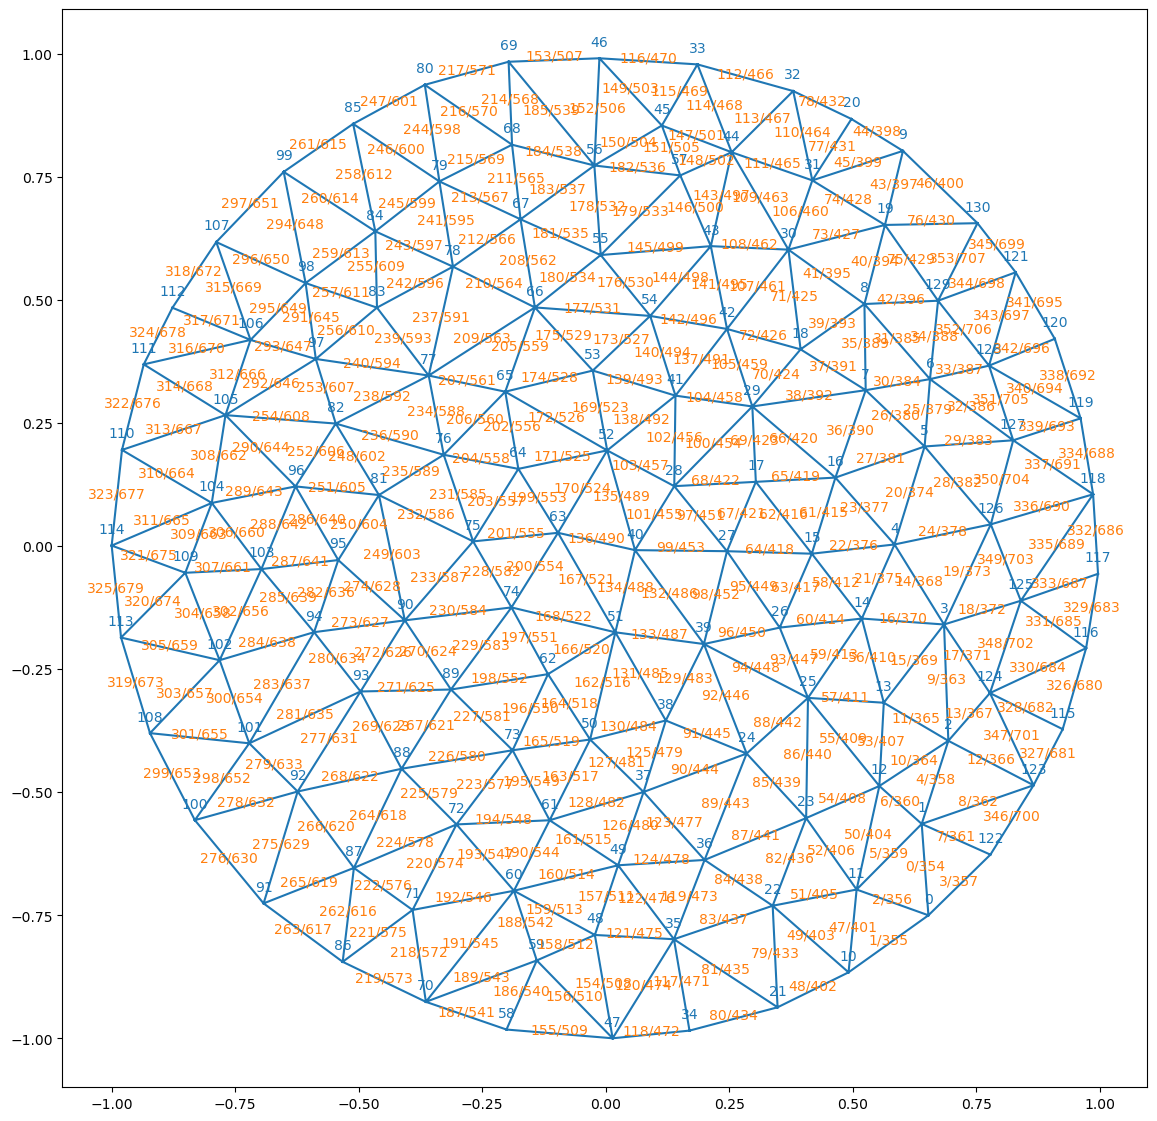

In [26]:
fig = plt.figure(figsize=(14,14))

plt.triplot(*mesh.vertices.T, hemesh.faces)
label_plot(mesh.vertices, hemesh.faces, fontsize=10, hemesh=hemesh, face_labels=False)
plt.axis("equal")

In [27]:
#| notest

# here is how you would do mesh traversal with jax.lax. The issues is that the output size needs to be fixed
# ahead of time, so 

self = hemesh
max_valence = 10
v = 10

initial = jnp.hstack([jnp.array([self.incident[v]]), -1*jnp.ones(max_valence-1, dtype=int)])
jax.lax.fori_loop(1, max_valence, lambda i, x: x.at[i].set(self.twin[x[i-1]]), initial)

Array([ 47, 401,  47, 401,  47, 401,  47, 401,  47, 401], dtype=int64)

#### Computing with half-edge meshes

By using the arrays of a half-edge meshes to index vertex- or face-positions (in increasingly complex ways), we can compute all sorts of quantities of interests associated with a mesh, for example the edge lengths.

In [ ]:
edges = mesh.vertices[hemesh.orig]-mesh.vertices[hemesh.dest]
lengths = jnp.linalg.norm(edges, axis=-1)

### Boundary and the vertex at infinity

So far, our mesh representations `TriMesh` and `HeMesh` work for triangular meshes with and without boundary. In the `HeMesh` class, boundary half-edges are assigned to a fictitious `-1` face. This convention has a downside. It is not possible to modify the boundary loop of the mesh by edge flips - doing so would result in an invalid state. In a simulation, this artificially limits the mesh's ability to deform. Instead, we can add "vertices at infinity" and connect al edges in a given boundary to $\infty$. This turns the mesh into a topological sphere. Now, one can flip boundary edges without the overall number of half-edges changing (so the array shape stays the same). Multiple boundaries are also supported. Each boundary corresponds to a distinct $\infty$-vertex (for example, 2 for a cylinder).

The coordinates of the fictitious vertices are set to `[np.inf, np.inf]` by convention. The boundary is found by iterating around $\infty$.
By convention, $\infty$-vertices, if they exists, are the final vertices of the mesh (don't rely on this - implementation detail). 

We generally assume that the mesh has only a single connected component.

The `HeMesh` class can deal with both the -1-face and the $\infty$-vertices conventions. The latter are listed in the `inf_vertices` attribute of a `HeMesh`.

In [28]:
#| export

def connect_boundary_to_infinity(vertices: Float[jax.Array, "n_vertices 2"],
                                 faces: Int[jax.Array, "n_faces 3"]
                                ) -> tuple[Float[jax.Array, "n_vertices_new 2"],
                                           Int[jax.Array, "n_faces_new 3"],
                                           tuple[int]]:
    """
    Connect boundary loop(s) to infinity.
    
    New vertices are appeneded to the end of vertex array and have coordinates [np.inf, np.inf].

    Parameters 
    ----------
    vertices : Float[jax.Array, "n_vertices 2"]
        Vertex positions.
    faces : Int[jax.Array, "n_faces 2"]
        Faces (triangles) as list of vertex indices.

    Returns
    -------
    new_vertices : Float[jax.Array, "n_vertices_new 2"]
        Vertex positions with infinity vertices appended.
        One infinity vertex per boundary loop.
    new_faces : Int[jax.Array, "n_faces_new 2"]
        Faces (triangles) as list of vertex indices, with new faces added to connect
        boundary loops to infinity vertices.
    inf_vertices : tuple[Int]
        Indices of infinity vertices in new_vertices.
        Will be (n_vertices, n_vertices+1, ..., n_vertices+n_boundaries-1).
    """
    boundary_loops = igl.boundary_loop_all(mesh.faces)
    new_vertices = jnp.copy(vertices)
    new_faces = jnp.copy(faces)

    for loop in boundary_loops:
        inf_index = vertices.shape[0]
        inf_faces = np.stack([[inf_index, v2, v1] for v1, v2 in zip(loop, np.roll(loop, -1))])
        new_vertices = jnp.vstack([new_vertices, jnp.inf*jnp.ones_like(new_vertices[:1])])
        new_faces = jnp.vstack([faces, inf_faces])
    
    return new_vertices, new_faces, tuple(range(vertices.shape[0], new_vertices.shape[0]))

In [29]:
mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)

  o flat_tri_ecmc


In [30]:
new_vertices, new_faces, infinity_vertices = connect_boundary_to_infinity(mesh.vertices, mesh.faces)
mesh_infty = TriMesh(vertices=new_vertices, faces=new_faces)
hemesh_infty = HeMesh.from_triangles(mesh_infty.vertices.shape[0], mesh_infty.faces,
                                     inf_vertices=infinity_vertices)

In [ ]:
# to get back the original faces/vertices, do this:

_ = hemesh_infty.faces[~hemesh_infty.is_inf_face]

# if you want to re-index the triangles so they only refer to non-infinity vertices:
_ = igl.remove_unreferenced(new_vertices, np.asarray(hemesh_infty.faces[~hemesh_infty.is_inf_face]) )

In [904]:
test_mesh_validity(hemesh_infty), (hemesh.is_bdry == (hemesh_infty.is_bdry[:-1] >0)).all()

(True, Array(True, dtype=bool))

## Mesh geometry and per-mesh variables

Mesh geometry (vertex and face positions) and per-mesh-item (per-face, per-half-edge, per-vertex) variables are combined into a second data class, the `GeomMesh`.

In [36]:
#| export

@jax.tree_util.register_dataclass
@dataclasses.dataclass(repr=False, eq=False, frozen=True,)
class GeomMesh:
    """
    Data class for holding mesh geometry and mesh-associated variables.
    To be combined with a HeMesh to specify the connectivity.

    One array (for vertex positions) must always be present. A second,
    but optional, standard entry is a set of positions for each face. 
    The mesh coordinates can live in 2d or 3d.
    
    Optionally, vertices, half-edges, and faces can have attributes (stored as dictionaries).
    The keys of the dictionary should be taken from a suitable 'enum'. The values are 
    ndarrays, whose 0th axis is (vertices/edges/faces). These attribute dicts are
    initialized empty and can be set afterwards.

    See documentation on HeMesh
    
    **Attributes**

    vertices : Float[jax.Array, "n_vertices 2"]

    face_positions : Float[jax.Array, "n_faces 2"]

    vertex_attribs : dict[IntEnum, Float[jax.Array, "n_vertices *"]]

    he_attribs : dict[IntEnum, Float[jax.Array, "n_hes *"]]

    face_attribs : dict[IntEnum, Float[jax.Array, "n_faces *"]]
    
    **Property methods (use like attributes)**

    n_items : tuple[int, int, int]

    dim : int

    **Class methods**

    validate_dimensions : bool

    **Static methods**
    
    load : str -> GeomHeMesh

    """

    n_vertices : int = dataclasses.field(metadata=dict(static=True))
    n_hes : int = dataclasses.field(metadata=dict(static=True))
    n_faces : int = dataclasses.field(metadata=dict(static=True))
    vertices : Float[jax.Array, "*batch n_vertices dim"]
    face_positions : Float[jax.Array, "*batch n_faces 2"] = dataclasses.field(default_factory=lambda : jnp.array([]))
    vertex_attribs : dict[IntEnum, Float[jax.Array, "... n_vertices"]] = dataclasses.field(default_factory=dict)
    he_attribs : dict[IntEnum, Float[jax.Array, "... n_hes"]] = dataclasses.field(default_factory=dict)
    face_attribs : dict[IntEnum, Float[jax.Array, "... n_faces"]] = dataclasses.field(default_factory=dict)
    
    @property
    def n_items(self) -> tuple[int, int, int]:
        return (self.n_vertices, self.n_hes, self.n_faces)

    @property
    def dim(self) -> int:
        return self.vertices.shape[-1]
    
    def __repr__(self) -> str:
        return "GeomMesh(D={},N_V={}, N_HE={}, N_F={})".format(*((self.dim,)+self.n_items))

    def validate_dimensions(self) -> None:
        """Validate input dimensions"""
        if (self.n_vertices != self.vertices.shape[0]):
            raise ValueError("Number of vertices inconsistent")
        if (self.face_positions.shape[0] not in [0, self.n_faces]):
            raise ValueError("Number of faces inconsistent")
        if any([val.shape[0] != self.n_vertices for _, val in self.vertex_attribs.items()]):
            raise ValueError("Vertex property dimension inconsistent")
        if any([val.shape[0] != self.n_hes for _, val in self.he_attribs.items()]):
            raise ValueError("Half-edge property dimension inconsistent")
        if any([val.shape[0] != self.n_faces for _, val in self.face_attribs.items()]):
            raise ValueError("Face property dimension inconsistent")
        return None

    def check_compatibility(self, hemesh: HeMesh) -> bool:
        return self.n_items==hemesh.n_items
    
    ## copying, loading, and saving
    
    def __copy__(self):
        return GeomMesh(*self.n_items, vertices=self.vertices, face_positions=self.face_positions,
                   vertex_attribs={key: jnp.copy(val) for key, val in self.vertex_attribs.items()},
                   he_attribs={key: jnp.copy(val) for key, val in self.he_attribs.items()},
                   face_attribs={key: jnp.copy(val) for key, val in self.face_attribs.items()})

    def save(self, file: str | Path) -> None:
        """Save HeMesh and all geometric attributes to two .npz archives of jnp.arrays"""
        np.savez(file,
             n_vertices=self.n_vertices, n_hes=self.n_hes, n_faces=self.n_faces,
             vertices=self.vertices, face_positions = self.face_positions,
             **{f"VertexAttribs.{key.name}": val for key, val in self.vertex_attribs.items()},
             **{f"HeAttribs.{key.name}": val for key, val in self.he_attribs.items()},
             **{f"FaceAttribs.{key.name}": val for key, val in self.face_attribs.items()},
             allow_pickle=False)
        return None

    @staticmethod
    def load(file: str | Path) -> "GeomMesh":
        """
        Note: vertex/he/face attribute dict's will have _strings_ as keys.
        
        To convert them back to Enums, do something like this:
        dataclasses.replace(geommesh, vertex_attribs={MyEnum[key]: val
                            for key, val in geom_mesh.vertex_attribs.items()})
        """
        npzfile = jnp.load(file)
        vertex_attribs = {key.split(".")[1]: val
                          for key, val  in npzfile.items() if key.split(".")[0] == "VertexAttribs"}
        he_attribs = {key.split(".")[1]: val
                      for key, val  in npzfile.items() if key.split(".")[0] == "HeAttribs"}
        face_attribs = {key.split(".")[1]: val
                        for key, val  in npzfile.items() if key.split(".")[0] == "FaceAttribs"}
        return GeomMesh(n_vertices=npzfile['n_vertices'].item(),
                        n_hes=npzfile['n_hes'].item(),
                        n_faces=npzfile['n_faces'].item(),
                        vertices=npzfile['vertices'],
                        face_positions=npzfile['face_positions'],
                        vertex_attribs=vertex_attribs,
                        he_attribs=he_attribs,
                        face_attribs=face_attribs)

    # equality comparisons. Two meshes are equal if all of the arrays they contain are equal.
    
    def __eq__(self, other: Any) -> bool:
        if not isinstance(other, GeomMesh):
            return False          
        if not self.n_items==other.n_items:
            return False
        return jax.tree_util.tree_all(jax.tree.map(jnp.allclose, jax.tree_util.tree_flatten(self)[0],
                                                                 jax.tree_util.tree_flatten(other)[0]))

In [38]:
#| export

class Mesh(NamedTuple):
    """Combine geometric and connectivity info into a single object."""
    geommesh: GeomMesh
    hemesh: HeMesh

In [39]:
mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)
geommesh = GeomMesh(*hemesh.n_items, mesh.vertices, mesh.face_positions)
combined_mesh = Mesh(geommesh, hemesh)
combined_mesh

  o flat_tri_ecmc


Mesh(geommesh=GeomMesh(D=2,N_V=131, N_HE=708, N_F=224), hemesh=HeMesh(N_V=131, N_HE=708, N_F=224))

In [40]:
leafs, ts = jax.tree_util.tree_flatten(geommesh) # also a pytree
ts

PyTreeDef(CustomNode(GeomMesh[(131, 708, 224)], [*, *, {}, {}, {}]))

In [41]:
geommesh, geommesh.n_vertices, geommesh.vertices.shape, geommesh.check_compatibility(hemesh), geommesh == geommesh

(GeomMesh(D=2,N_V=131, N_HE=708, N_F=224), 131, (131, 2), True, True)

In [42]:
#| export

def cellplot(hemesh: HeMesh, face_positions: Float[jax.Array, "n_faces 2"],
             cell_colors: None | str | Float[np.ndarray, "4"] | Float[np.ndarray, "n_vertices 4"] =None,
             mpl_polygon_kwargs: None | dict[str, Any] = None) -> mpl.collections.PatchCollection:
    """
    Plot a cell tesselation.
    
    cell_colors can be either a single color (for all cells) or a vector of rgba values.
    Only interior cells are plotted.
    """
    if mpl_polygon_kwargs is None:
        mpl_polygon_kwargs = {"lw": 1, "ec": "k"}
    # formatting for the cell colors - make into a list
    if cell_colors is None:
        cell_colors = np.zeros((hemesh.n_vertices, 4))
    if isinstance(cell_colors, str):
        cell_colors = [cell_colors for v in range(hemesh.n_vertices)]
    if isinstance(cell_colors, Iterable):
        assert len(cell_colors) in [4, hemesh.n_vertices], "Cell color must be 1 or n_vertices rgba values"
        if len(cell_colors) == 4:
            cell_colors = [cell_colors for v in range(hemesh.n_vertices)]
    # iterate over non-boundary vertices.
    polygons = []
    bdry = hemesh.is_bdry
    for v in range(hemesh.n_vertices):
        if not bdry[v]:
            polygon_edges = hemesh.iterate_around_vertex(v)
            polygon_vertices = face_positions[hemesh.heface[np.array(polygon_edges)]]
            polygons.append(mpl.patches.Polygon(polygon_vertices, color=cell_colors[v], **mpl_polygon_kwargs))
    return mpl.collections.PatchCollection(polygons, match_original=True)

(np.float64(-1.10003475),
 np.float64(1.09628575),
 np.float64(-1.09934025),
 np.float64(1.09050125))

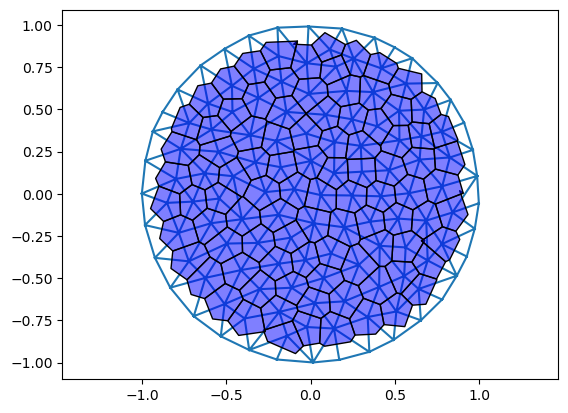

In [43]:
plt.triplot(*geommesh.vertices.T, hemesh.faces)
polygons = cellplot(hemesh, geommesh.face_positions,
                    cell_colors=np.array([0,0,1,0.5]), mpl_polygon_kwargs={"lw": 1, "ec": "k"})
ax = plt.gca()
ax.add_collection(polygons)

plt.axis("equal")



### Vertex, half-edge, and face properties

In simulations, we will often want to attach extra information to a mesh's vertices/edges/faces. In the `GeomMesh` class, these are saved in three dictionaries, `vertex_attribs`, `he_attribs`, `face_attribs`. Each key/value pair represents one property (for example, the cell target area). All values are arrays, and the first axis corresponds to the number of vertices/half-edges/faces, respectively.
To keep track of the possible attributes, we use `IntEnum`'s as keys (this also ensures keys are hashable, as required by JAX)

In [44]:
mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)
geommmesh = GeomMesh(*hemesh.n_items, mesh.vertices, mesh.face_positions)

  o flat_tri_ecmc


In [45]:
# this is how you set up an enum. It is important to use IntEnum, so we can _order_ the enums.
# The precise Enum you will use depends on your application.

class VertexAttribs(IntEnum):
    TARGET_AREA = 1
    TARGET_PERIMETER = 2

class HeAttribs(IntEnum):
    EDGE_TENSION = 1

class FaceAttribs(IntEnum):
    FACE_AREA = 1



In [46]:
# you can iterate over enums, and they are hashable. The latter is essential for JAX!
print([a for a in VertexAttribs])
# there are multiple ways to access enum entries:
hash(VertexAttribs.TARGET_PERIMETER), HeAttribs.EDGE_TENSION, HeAttribs['EDGE_TENSION'], HeAttribs.EDGE_TENSION.name


[<VertexAttribs.TARGET_AREA: 1>, <VertexAttribs.TARGET_PERIMETER: 2>]


(2, <HeAttribs.EDGE_TENSION: 1>, <HeAttribs.EDGE_TENSION: 1>, 'EDGE_TENSION')

In [47]:
# at initialization, a HeMesh's attribute dictionaries are empty
geommmesh.vertex_attribs

{}

In [48]:
# set some attributes

key1 = jax.random.key(0)
_, key2 = jax.random.split(key1)
_, key3 = jax.random.split(key2)

geommmesh = dataclasses.replace(geommmesh, vertex_attribs={VertexAttribs.TARGET_AREA: jax.random.normal(key=key1,shape=geommmesh.n_vertices),
                                                           VertexAttribs.TARGET_PERIMETER: jax.random.normal(key=key2, shape=geommmesh.n_vertices)})
geommmesh = dataclasses.replace(geommmesh, he_attribs={HeAttribs.EDGE_TENSION: jax.random.normal(key=key3, shape=geommmesh.n_hes)})

In [49]:
geommmesh.he_attribs.keys()

dict_keys([<HeAttribs.EDGE_TENSION: 1>])

## Batching

In our simulations, we may want to "batch" over several initial conditions/random seeds/etc (analogous to batching over training data in normal ML). In JAX, we can efficiently and concisely vectorize operations over such "batch axes" with `jax.vmap`. 

To batch over our custom data structures, we need to pull a small trick - convert a list of `HeMesh`/`GeomMeshe` instances into a single mesh with a batch axis for the various arrays. Luckily, this can be [done using JAX's pytree tools](https://stackoverflow.com/questions/79123001/storing-and-jax-vmap-over-pytrees).
The resulting meshes have an extra "batch" axis in all their array.

In [50]:
#| export

def tree_stack(xs : list[PyTree], axis=0) -> PyTree:
    """Stack a sequence of identical-structure pytrees along a new axis."""
    return jax.tree.map(lambda *leaves: jnp.stack(leaves, axis=axis), *xs)

def tree_unstack(xb: PyTree, axis=0) -> list[PyTree]:
    """Unstack a batched pytree along axis into a list of pytrees."""
    leaves, treedef = jax.tree.flatten(xb)
    B = leaves[0].shape[axis]
    # split every leaf along batch dimension
    per = [jax.tree.unflatten(treedef, [leaf.take(indices=i, axis=axis)  for leaf in leaves])
           for i in range(B)]
    return per

In [51]:
## Let us create a bunch of meshes with different initial positions and see if we can batch over them using vmap

key = jax.random.key(0)
sigma = 0.02

batch_geom = []
batch_he = []
for i in range(3):
    key, subkey = jax.random.split(key)
    random_noise = jax.random.normal(subkey, shape=geommmesh.vertices.shape)
    batch_geom.append(dataclasses.replace(geommmesh, vertices=geommmesh.vertices+sigma*random_noise))
    batch_he.append(copy.copy(hemesh))

In [52]:
# define a test function to appy over the batch

def test_function(geommesh: GeomMesh, hemesh: HeMesh) -> Float[jax.Array, " n_vertices"]:
    """Dummy test function."""
    return jnp.ones(geommesh.n_vertices)

In [53]:
%unload_ext jaxtyping

In [54]:
#| notest

# naive batching does not work. JAX needs a "struct-of-arrays", but a list of HeMeshes is an "array-of-structs"
# see https://stackoverflow.com/questions/79123001/storing-and-jax-vmap-over-pytrees

try:
    jax.vmap(test_function)(batch_geom, batch_he)
except ValueError as e:
    print("Expected error:", e)

Expected error: vmap got inconsistent sizes for array axes to be mapped:
  * most axes (21 of them) had size 708, e.g. axis 0 of argument geommesh[0].he_attribs[<HeAttribs.EDGE_TENSION: 1>] of type float64[708];
  * some axes (12 of them) had size 131, e.g. axis 0 of argument geommesh[0].vertices of type float64[131,2];
  * some axes (6 of them) had size 224, e.g. axis 0 of argument geommesh[0].face_positions of type float64[224,2]


In [55]:
# instead, we use a jax.tree.map to "push" the list axis into the underlying arrays.
# the resulting meshes have an extra batch dimension in all of their arrays.

batch_he_array = tree_stack(batch_he)
batch_geom_array = tree_stack(batch_geom)
batch_he_array, batch_geom_array, batch_geom_array.vertices.shape

(HeMesh(N_V=131, N_HE=708, N_F=224),
 GeomMesh(D=2,N_V=131, N_HE=708, N_F=224),
 (3, 131, 2))

In [56]:
# now it works! The result is a single object with batch axis

batch_out =jax.vmap(test_function)(batch_geom_array, batch_he_array)
batch_out.shape

(3, 131)

In [57]:
# we can unpack things again into a list of meshes

isinstance(tree_unstack(batch_out), list)

True

## Saving to disk


We save and load `TriMesh` meshes as standard `.obj` files (with the hack of using `vn` lines for the face positions). The `HeMesh` class is basically a collection of arrays, which we can save to disk using `numpy`.


In [85]:
from tempfile import TemporaryFile

In [86]:
mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)

  o flat_tri_ecmc


In [87]:
#| hide

# this is how to use np.savenpz

outfile = TemporaryFile()

x = np.arange(10)
y = np.sin(x)

np.savez(outfile, x=x, y=y)
_ = outfile.seek(0) # simulates closing & reopening file

npzfile = np.load(outfile)
sorted(npzfile.files), npzfile['x']

(['x', 'y'], array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [88]:
outfile = TemporaryFile()

hemesh.save(outfile)
_ = outfile.seek(0) # simulates closing & reopening file
npzfile = np.load(outfile)
npzfile.files

['incident',
 'orig',
 'dest',
 'twin',
 'nxt',
 'prv',
 'heface',
 'face_incident',
 'inf_vertices']

In [89]:
outfile = TemporaryFile()

hemesh.save(outfile)
_ = outfile.seek(0) # simulates closing & reopening file
reloaded = HeMesh.load(outfile)

np.allclose(reloaded.faces, hemesh.faces)

True